In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors

In [5]:
class Blob():
    strains_full = ['Team', 'Selfish', 'Intelligent']
    strains = ['T', 'S', 'I']
    
    def __init__(self, strain):
        self.food = 0
        self.strain = strain
        
    def reproduce(self, mutation_table):
        out = []
        for _ in range(int(self.food//1 + ((self.food - self.food//1) > np.random.rand()))):
            new_strain = np.random.choice(self.strains, p=list(mutation_table[self.strain].values()))
            out.append(Blob(new_strain))
        return out
    
    def __str__(self):
        return f'{self.food}, {self.strain}'

In [75]:
class Tree():
    reward_matrix = {'T': {'T': 7/4, 'S': 2/4}, 
                     'S': {'T': 6/4, 'S': 3/4}}
    
    def __init__(self):
        self.blobs = []
        
    def harvest(self, communication):
        if len(self.blobs) == 0: 
            return
        elif len(self.blobs) == 1:
            self.blobs[0].food = self.reward_matrix['S']['T'] + self.reward_matrix['T']['S']
        else:
            strain0 = self.blobs[0].strain
            strain1 = self.blobs[1].strain
            
            if self.blobs[0].strain == 'I' and self.blobs[1].strain != 'I':
                strain0 = 'T' if self.reward_matrix['T'][self.blobs[1].strain] > self.reward_matrix['S'][self.blobs[1].strain] else 'S'
            elif self.blobs[0].strain != 'I' and self.blobs[1].strain == 'I':
                strain1 = 'T' if self.reward_matrix['T'][self.blobs[0].strain] > self.reward_matrix['S'][self.blobs[0].strain] else 'S'
            elif self.blobs[0].strain == 'I' and self.blobs[1].strain == 'I':
                strain0 = 'T' if communication else 'S'
                strain1 = 'T' if communication else 'S'
            
            self.blobs[0].food = self.reward_matrix[strain0][strain1]
            self.blobs[1].food = self.reward_matrix[strain1][strain0]
            
    def reset(self):
        self.blobs = []

In [76]:
class Simulator():
    mutation_table = {'T': {'T': 1, 'S': 0, 'I': 0},
                      'S': {'T': 0, 'S': 1, 'I': 0},
                      'I': {'T': 0, 'S': 0, 'I': 1}}
    
    def __init__(self, init_blobs=10, init_trees=50):
        self.init_blobs = init_blobs
        self.reset_blobs()
        
        self.init_trees = init_trees
        self.trees = np.array([Tree() for _ in range(self.init_trees)])
        
        self.communication = True
        
    def reset_blobs(self, *args):
        if args:
            self.blobs = np.array([Blob(Blob.strains[i]) for i, v in enumerate(args) for _ in range(v)])
        else:
            self.blobs = np.array([Blob('S' if 0.5 > np.random.rand() else 'T') for _ in range(self.init_blobs)])
            
    def reset_trees(self):
        for tree in self.trees: tree.reset()
        
    def find_trees(self):
        for i in range(min(2*self.init_trees, len(self.blobs))):
            self.trees[i%self.init_trees].blobs.append(self.blobs[i])
        
    def harvest_trees(self):
        for tree in self.trees: tree.harvest(self.communication)
        
    def next_gen(self):
        num_blobs = len(self.blobs)
        
        for i in range(num_blobs): 
            self.blobs = np.append(self.blobs, self.blobs[i].reproduce(self.mutation_table))
        for _ in range(num_blobs): 
            self.blobs = self.blobs[1:]
            
        np.random.shuffle(self.blobs)
            
    def print_blobs(self):
        for blob in self.blobs: print(str(blob))
        
    def count_blobs(self, strain=None):
        strains = [blob.strain for blob in self.blobs]
        return strains.count(strain) if strain else [strains.count(strain) for strain in Blob.strains]
        
    def update_data(self, data, with_counts):
        counts = self.count_blobs()
        props = [count / len(self.blobs) for count in counts]
        return np.append(data, counts if with_counts else props)
            
    def day(self):
        self.reset_trees()
        self.find_trees()
        self.harvest_trees()
        self.next_gen()
        
    def run(self, days=100, sims=1, with_counts=False, num_blobs=[]):
        self.data = []
        
        for i in range(sims):
            if num_blobs: self.reset_blobs(*num_blobs)
            else: self.reset_blobs(*[round(elem*self.init_blobs/(sims+1)) for elem in [i+1, sims-i]])
            new_data = self.update_data([], with_counts)
            
            for _ in range(days):
                self.day()
                new_data = self.update_data(new_data, with_counts)
            self.data = np.append(self.data, new_data.reshape(days+1, len(Blob.strains)).T)
            
        self.data = self.data.reshape(sims, len(Blob.strains), days+1)
            
    def plot_data(self, with_lines=True):
        fig, ax = plt.subplots()
        dshape = self.data.shape
        
        x = np.arange(0, dshape[2])
        avgs = np.zeros(dshape[1:])
        
        for i in range(dshape[0]):
            sum_data = np.zeros(dshape[2])
            for j in range(dshape[1]):
                sum_data += self.data[i][j]
                avgs[j] += self.data[i][j]
                if with_lines: ax.plot(x, sum_data, color='#FFFFFF')
                
        avgs /= dshape[0]
        legend = [strain for i, strain in enumerate(Blob.strains_full) if sum(avgs[i])]
        ax.stackplot(x, *avgs, labels=legend, colors=colors.TABLEAU_COLORS)
        
        ax.legend()
        ax.set(title="Blobs Over Time", xlabel='Days', ylabel=('Proportion of Blobs' if sum_data[-1] == 1 else 'Number of Blobs'))
        plt.show()

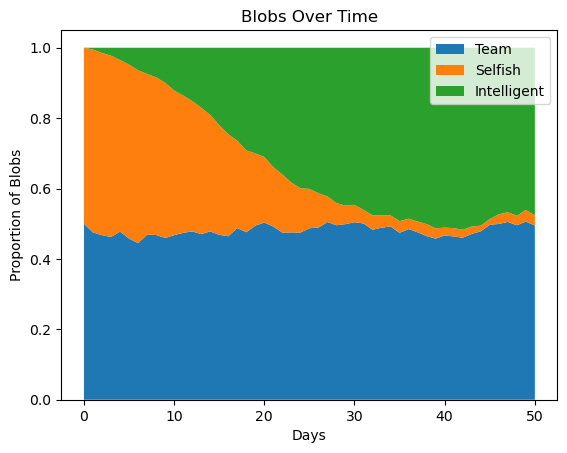

In [77]:
simulator = Simulator()
simulator.mutation_table = {'T': {'T': 0.98, 'S': 0.01, 'I': 0.01},
                            'S': {'T': 0.01, 'S': 0.98, 'I': 0.01},
                            'I': {'T': 0.01, 'S': 0.01, 'I': 0.98}}
simulator.run(days=50, sims=10)
simulator.plot_data(with_lines=False)